<a href="https://colab.research.google.com/github/Daniel120622/Final-Year-Project/blob/main/First%20method_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Stable diffusion in Colab


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchvision==0.18.1
!pip install diffusers transformers torch xformers controlnet_aux opencv-python==4.6.0.66
!wget https://download.pytorch.org/whl/cpu/torchvision-0.17.1%2Bcpu-cp310-cp310-linux_x86_64.whl
!pip install openai
!pip install mediapipe
!wget -O selfie_mutliclass_256x256.tflite -q https://storage.googleapis.com/mediapipe-models/image_segmenter/selfie_multiclass_256x256/float32/latest/selfie_multiclass_256x256.tflite
model_path = '/content/selfie_mutliclass_256x256.tflite'



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 107.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, EulerDiscreteScheduler, UniPCMultistepScheduler
import torch
from diffusers.utils import load_image, make_image_grid
from PIL import Image
import cv2
import numpy as np
from controlnet_aux import OpenposeDetector

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import os
from google.colab import files
from PIL import Image

# Part four
import os
from google.colab import userdata
from openai import OpenAI
import json
from google.colab import files
import ipywidgets as widgets
from IPython.display import display
import glob
from typing import List

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np
from google.colab.patches import cv2_imshow

import cv2
import numpy as np
from controlnet_aux import OpenposeDetector


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

# 2. ⁠upload the picture there


In [ ]:
# Upload Two PNG Files in Google Colab

#@markdown This code allows you to upload two PNG files with specific dimensions (either 512x512 or 768x762). Follow these steps to upload the files separately:
#@markdown 1. Run the code below.
#@markdown 2. Upload exactly two PNG files when prompted.


# Function to upload multiple files
def upload_folder():
    print("Please upload your folder containing two photos (same size = 512x512 or 768x762).")
    uploaded = files.upload()

    # Save each uploaded file and get their paths
    file_paths = []
    for filename in uploaded.keys():
        file_path = os.path.join("/content", filename)  # Save in the Colab environment
        with open(file_path, "wb") as f:
            f.write(uploaded[filename])
        file_paths.append(file_path)

    print("Files uploaded successfully.")
    return file_paths

# Upload the images for person and cloth
uploaded_person = upload_folder()
uploaded_cloth = upload_folder()

# Get the path of the uploaded cloth image
cloth_image_path = uploaded_cloth[0]  # Assuming the first uploaded file is the cloth image
person_image_path = uploaded_person[0]

# Test with the cloth image path
test_image_path = cloth_image_path
test_image_person_path = person_image_path





Please upload your folder containing two photos (same size = 512x512 or 768x762).


Saving T-shirt.jpeg to T-shirt.jpeg
Files uploaded successfully.
Please upload your folder containing two photos (same size = 512x512 or 768x762).


Saving person.png to person.png
Files uploaded successfully.


In [ ]:
print(test_image_path)
print(test_image_person_path)

/content/person.png
/content/T-shirt.jpeg


# Mediapipe



In [ ]:
BG_COLOR = (0, 0, 0) # gray
CLOTHES_MASK_COLOR = (255, 255, 255) # white

# Create the options for the Multi-class selfie segmentation model
base_options = python.BaseOptions(model_asset_path='selfie_mutliclass_256x256.tflite')
options = vision.ImageSegmenterOptions(base_options=base_options,
                                       output_category_mask=True)

# Create the image segmenter
with vision.ImageSegmenter.create_from_options(options) as segmenter:

        image = mp.Image.create_from_file(IMAGE_PATH)

        # Retrieve the masks for the segmented image
        segmentation_result = segmenter.segment(image)
        category_mask = segmentation_result.category_mask

        # Generate solid color images for showing the output segmentation mask.
        image_data = image.numpy_view()
        fg_image = np.zeros(image_data.shape, dtype=np.uint8)
        fg_image[:] = CLOTHES_MASK_COLOR
        bg_image = np.zeros(image_data.shape, dtype=np.uint8)
        bg_image[:] = BG_COLOR

        # Mask only the clothes category (class 4)
        condition = (category_mask.numpy_view() == 4)
        condition = np.stack((condition,) * 3, axis=-1)  # Expand dimensions for RGB

        # Generate the output image with clothes highlighted
        output_image = np.where(condition, fg_image, bg_image)

        # Display the segmentation result
        print('Segmentation mask of clothes T_shirt')

def resize_and_show(image, output_path, window_name='Segmentation Output'):
    resized_image = cv2.resize(image, (512, 512)) # Resize to a manageable size for display
    cv2_imshow(resized_image)  # Display the image in Colab
    cv2.imwrite(output_path, resized_image)  # Save the image to the specified path
    print(f'Output image saved at {output_path}')
    cv2.waitKey(0)
    cv2.destroyAllWindows()

resize_and_show(output_image, OUTPUT_PATH)
masked_output = output_image



# 3. ⁠use that picture to classify by model

In [ ]:
class_names = ['Blazer', 'Blouse', 'Body', 'Dress', 'Hat', 'Hoodie', 'Longsleeve', 'Not sure', 'Other', 'Outwear', 'Pants', 'Polo', 'Shirt', 'Shoes', 'Shorts', 'Skip', 'Skirt', 'T-Shirt', 'Top', 'Undershirt']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))


model.load_state_dict(torch.load('/content/drive/MyDrive/Final Year Project/model/Final_model.pth'))
model = model.to(device)
model.eval()

<ipython-input-11-597e19ca6dff>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Final Year Project/model/Final_mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def preprocess_image(image_path):
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

def predict_image(model, image_path):
    image = preprocess_image(image_path)
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)

    return class_names[preds[0]]


prediction = predict_image(model, test_image_path)
print(f'The predicted class is: {prediction}')



The predicted class is: Dress


# 4. ⁠Output the classify result

In [ ]:
# Function to upload multiple files
from google.colab import userdata


my_secret_key = userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
client = OpenAI(api_key= my_secret_key)
my_assistant = client.beta.assistants.retrieve('asst_fT3umHwSshAgGNSkUoVde1aJ')

In [ ]:
# Function to create a new thread and send a user message
def create_a_thread():
    thread = client.beta.threads.create()
    user_input = f"Please provide a positive prompt, negative prompt and some detailed parameter with exact number in stable diffusion to generate a {prediction} picture in stable diffusion"
    message = client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content=user_input
    )
    return thread.id

# Function to run and display thread messages
def run_n_display(thread_id):
    run = client.beta.threads.runs.create_and_poll(
        thread_id=thread_id,
        assistant_id=my_assistant.id,
        instructions="Please address the user. The user has a premium account."
    )

    if run.status == 'completed':
        messages = client.beta.threads.messages.list(
            thread_id=thread_id
        )
        messages_data = messages.data  # Access the data attribute directly
        for message in messages_data:
            if message.role == 'assistant':  # Only display messages from the assistant
                for content_block in message.content:
                    if content_block.type == 'text':
                        print(content_block.text.value)
    else:
        print(run.status)


In [ ]:
# Main function loop to create a thread, run, and display messages
thread_id = create_a_thread()
run_n_display(thread_id)

For generating a T-shirt picture in stable diffusion, here are some positive and negative prompts along with detailed parameters:

Positive Prompt:
- Dynamic view of a holographic magical hoodie design with detailed frame painting, appearing lifelike hanging on a wall, using magical multicolored ink, high-quality imagination, and vivid magical colors【4:3†source】.
- Luis Royo style acrylic paint and spray paint with intricate dark lighting, detailed featuring a girl with makeup, reflections, red moon, fog, silhouette, and high contrast ink strokes【4:3†source】.

Negative Prompt:
- Blurry human body or face, cartoon-like appearance, cluttered, bad quality, low resolution, or worst quality【4:3†source】.
- Teeth, open mouth, NSFW themes, naked or nude elements, mutated or disfigured features, thin or childlike figures, monochrome visuals, and low-quality characteristics【4:1†source】.

Detailed Parameters:
- For the holographic hoodie design: 
  - Steps: 40
  - Size: 832x1216
  - Seed: 4165682

# Multi ControlNet

# Use stable diffusion on colab locally.


/usr/local/lib/python3.10/dist-packages/controlnet_aux/open_pose/body.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.transfer(self.model, torch.load(

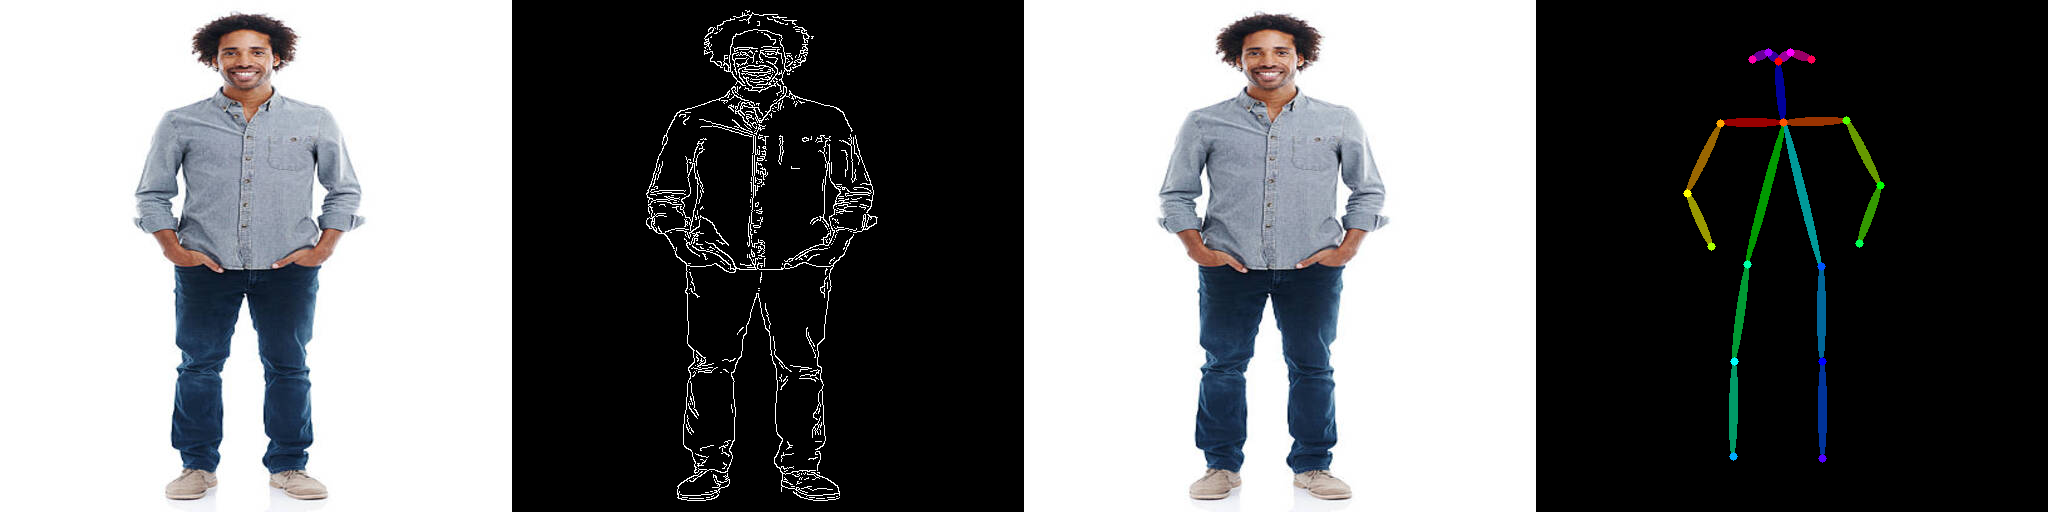

In [ ]:
cloth_image = load_image("https://huggingface.co/datasets/limitx9/fyp/resolve/main/cloth_image/T-shirt/Oversize-T-shirt%20(2).jpg")
person_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png")

# Load ControlNet models
controlnet_canny = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16
).to("cuda")

controlnet_pose = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16
).to("cuda")

canny_original_image = person_image

image = np.array(canny_original_image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)

#OpenPose

openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
original_image = person_image
openpose_image = openpose(original_image)
make_image_grid([canny_original_image, canny_image, original_image, openpose_image], rows=1, cols=4)


In [ ]:
controlnet = [
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16),
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16),
]

#pipe = StableDiffusionControlNetPipeline.from_pretrained(
#    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
#)

choose_model = "runwayml/stable-diffusion-v1-5"  # @param ["emilianJR/chilloutmix_NiPrunedFp32Fix","Lykon/DreamShaper", "stabilityai/stable-diffusion-2-1", "runwayml/stable-diffusion-v1-5"]

model_id = choose_model

# Assuming controlnet is already defined
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    model_id, controlnet=controlnet, torch_dtype=torch.float16
)
#change model in here

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_xformers_memory_efficient_attention()
pipe.enable_model_cpu_offload()

positve_prompt = "A man wear oversized T-shirt, cyberpunk"  #@param {type:"string"}
negative_prompt = "blurry,human body,human face, easy negative cartoon, cluttered blurry, bad quality, low quality ,worst quality,  wrong background" #@param {type:"string"}

#@markdown **Very Important! Num_inference_steps should be positive integer.**<br>
#@markdown <br>


#@markdown <br>

#@markdown **Scale should be ranging from 0 to 1. For example 0.5, 0.85, 0.9 are valid**

openpose_controlnet_conditioning_scale = 0.6  #@param{type:""}
canny_controlnet_conditioning_scale = 0.8 #@param{type:""}
num_inference_steps = 20 #@param{type:"integer"}


generator = torch.Generator(device="cpu").manual_seed(1)
prompt = positve_prompt
images = [openpose_image, canny_image]
scales = [0.8,1]

image = pipe(
    prompt,
    images,
    num_inference_steps = 20,
    generator=generator,
    negative_prompt=negative_prompt,
    controlnet_conditioning_scale=[openpose_controlnet_conditioning_scale, canny_controlnet_conditioning_scale],
).images[0]


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

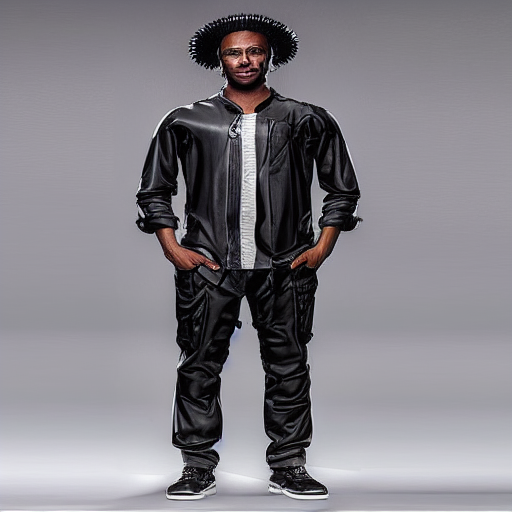

In [ ]:
image